In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from sklearn.metrics import accuracy_score, log_loss

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [4]:
train = pd.read_pickle('/home/dmitry/Desktop/DataDriven/train_prep.pkl')
test = pd.read_pickle('/home/dmitry/Desktop/DataDriven/test_prep.pkl')
sample = pd.read_csv('/home/dmitry/Desktop/DataDriven/SubmissionFormat.csv')

In [5]:
train.Season = le.fit_transform(train.Season)
test.Season = le.fit_transform(test.Season)

In [6]:
train = pd.get_dummies(train, columns=['Season'])
test = pd.get_dummies(test, columns=['Season'])

In [7]:
outcome = pd.read_csv('/home/dmitry/Desktop/DataDriven/Labels.csv', squeeze=True)

In [8]:
y = le.fit_transform(outcome.status_group)

In [9]:
pd.DataFrame(y).to_csv('/home/dmitry/Desktop/DataDriven/Y.csv') 

In [10]:
from pandas.core.common import array_equivalent

def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []

    for t, v in groups.items():

        cs = frame[v].columns
        vs = frame[v]
        lcs = len(cs)

        for i in range(lcs):
            ia = vs.iloc[:,i].values
            for j in range(i+1, lcs):
                ja = vs.iloc[:,j].values
                if array_equivalent(ia, ja):
                    dups.append(cs[i])
                    break

    return dups

In [11]:
dups = duplicate_columns(train)
train = train.drop(dups, axis=1)

In [12]:
dups = duplicate_columns(test)
test = test.drop(dups, axis=1)

## Train-Test Split

In [13]:
X = train

In [14]:
from sklearn.cross_validation import train_test_split

In [15]:
Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.15, random_state=42)

In [16]:
Xtr.shape, Xval.shape

((50490, 81), (8910, 81))

## Constant prediction

In [15]:
const = np.ones(shape=(8910, 1))*0

In [16]:
const

array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

In [17]:
accuracy_score(yval, const)

0.54332210998877661

In [18]:
yval[1:50]

array([0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 1, 0, 2, 2,
       0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0,
       0, 2, 0])

In [19]:
probas = np.array(pd.Series(ytr).value_counts(normalize=True).sort_index().tolist())
probas

array([ 0.54303823,  0.07292533,  0.38403644])

In [20]:
log_loss(yval, np.tile(probas, 8910).reshape(8910, 3))

0.88718610891533223

In [21]:
pd.Series(ytr).value_counts(normalize=True).sort_index()

0    0.543038
1    0.072925
2    0.384036
dtype: float64

## Logistic Regression

In [58]:
from sklearn.linear_model import LogisticRegression

In [23]:
lr = LogisticRegression()
lr.fit(Xtr, ytr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
print('Train logloss', log_loss(ytr, lr.predict_proba(Xtr)))
print('Validation logloss', log_loss(yval, lr.predict_proba(Xval)))

Train logloss 0.729860173424
Validation logloss 0.73323764495


In [25]:
print('Train accuracy score', accuracy_score(ytr, lr.predict(Xtr)))
print('Validation accuracy score', accuracy_score(yval, lr.predict(Xval)))

Train accuracy score 0.695147553971
Validation accuracy score 0.696071829405


### Hyperparameter optimization

In [55]:
from sklearn.grid_search import GridSearchCV

In [56]:
Cs = 10**np.linspace(-4, 4, num=15)
Cs

array([  1.00000000e-04,   3.72759372e-04,   1.38949549e-03,
         5.17947468e-03,   1.93069773e-02,   7.19685673e-02,
         2.68269580e-01,   1.00000000e+00,   3.72759372e+00,
         1.38949549e+01,   5.17947468e+01,   1.93069773e+02,
         7.19685673e+02,   2.68269580e+03,   1.00000000e+04])

In [59]:
grid = {'C': Cs}
gridsearch = GridSearchCV(LogisticRegression(), grid, scoring='accuracy', cv=6)

In [60]:
%time gridsearch.fit(ss.fit_transform(X), y)

CPU times: user 17min 8s, sys: 2.88 s, total: 17min 11s
Wall time: 16min 43s


GridSearchCV(cv=6, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-04,   3.72759e-04,   1.38950e-03,   5.17947e-03,
         1.93070e-02,   7.19686e-02,   2.68270e-01,   1.00000e+00,
         3.72759e+00,   1.38950e+01,   5.17947e+01,   1.93070e+02,
         7.19686e+02,   2.68270e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

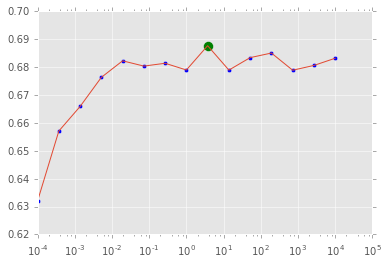

In [61]:
%matplotlib inline
scores = [x.mean_validation_score for x in  gridsearch.grid_scores_]
plt.plot(Cs, scores)
plt.scatter(Cs, scores)
plt.scatter(Cs[np.argmax(scores)], scores[np.argmax(scores)], c='g', s=100)
plt.xscale('log')

In [65]:
C = Cs[np.argmax(scores)]
C

3.7275937203149381

In [88]:
lr = LogisticRegression(C=C)
lr.fit(ss.fit_transform(Xtr), ytr)
print('Train logloss', log_loss(ytr, lr.predict_proba(ss.fit_transform(Xtr))))
print('Validation logloss', log_loss(yval, lr.predict_proba(ss.fit_transform(Xval))))
print('Train accuracy score', accuracy_score(ytr, lr.predict(ss.fit_transform(Xtr))))
print('Validation accuracy score', accuracy_score(yval, lr.predict(ss.fit_transform(Xval))))

Train logloss 0.686064820747
Validation logloss 0.689009535967
Train accuracy score 0.696494355318
Validation accuracy score 0.698428731762


In [67]:
lr.fit(X, y)

LogisticRegression(C=3.7275937203149381, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## Random Forest

In [68]:
from sklearn.ensemble import RandomForestClassifier

In [69]:
rf = RandomForestClassifier(n_estimators=200, n_jobs=3)
rf.fit(Xtr, ytr)
print(log_loss(yval, rf.predict_proba(Xval)))
print(accuracy_score(yval, rf.predict(Xval)))

0.531519836598
0.812570145903


In [196]:
answ = rf.predict(test)

In [197]:
answ = list(answ)

In [198]:
for i in range(len(answ)):
    if answ[i] == 0:
        answ[i] = 'functional'
    elif answ[i] == 1:
        answ[i] = 'functional needs repair'
    else:
        answ[i] = 'non functional'

In [199]:
answ[1:10]

['functional',
 'functional',
 'non functional',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'non functional',
 'functional']

In [200]:
sub = pd.DataFrame(sample.id)
sub['status_group'] = pd.DataFrame(answ, columns=sample.columns[1:])

In [201]:
sub.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [202]:
sub.to_csv('C://Users//Auditore//Desktop//DataDriven//submission.csv', index=False)

This random forest gave me 0.8076 score 

In [16]:
from sklearn.calibration import CalibratedClassifierCV

In [17]:
calib = CalibratedClassifierCV(RandomForestClassifier(n_jobs=3, n_estimators=200), cv=5, method='isotonic')
calib.fit(Xtr, ytr)
print(log_loss(yval, calib.predict_proba(Xval)))
print(accuracy_score(yval, calib.predict(Xval)))

0.477490658757
0.816049382716


In [18]:
answ = calib.predict(test)
answ = list(answ)

In [47]:
def classes_to_names(answ):
    clean = answ
    for i in range(len(answ)):
        if answ[i] == 0:
            clean[i] = 'functional'
        elif answ[i] == 1:
            clean[i] = 'functional needs repair'
        else:
            clean[i] = 'non functional'
    return clean

In [ ]:
answ = classes_to_names(answ)

In [19]:
sub = pd.DataFrame(sample.id)
sub['status_group'] = pd.DataFrame(answ, columns=sample.columns[1:])

In [20]:
sub.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [21]:
sub.to_csv('/home/dmitry/Desktop/DataDriven/submission.csv', index=False)

## XGBoost

In [17]:
import sys
sys.path.append('/home/dmitry/xgboost/python-package/')

In [18]:
import xgboost as xgb

In [19]:
X.shape, y.shape

((59400, 81), (59400,))

In [20]:
dtrain = xgb.DMatrix(X, label=y)

In [21]:
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'max_depth': 8,
    'eta': 2.5
}
trees = 50

In [70]:
cv = xgb.cv(params, dtrain, metrics=('merror'), verbose_eval=False, nfold=7, show_stdv=False, num_boost_round=trees)

In [ ]:
cv.head()

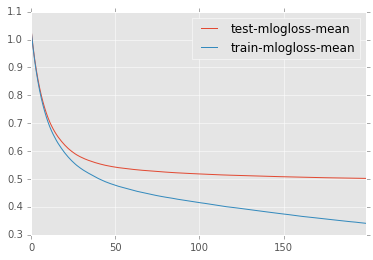

In [35]:
%matplotlib inline
cv.plot(y=['test-mlogloss-mean', 'train-mlogloss-mean'])

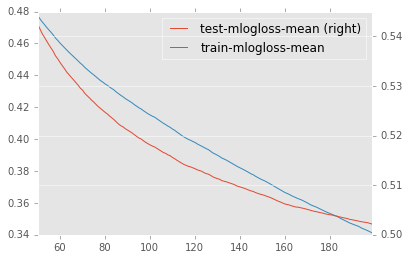

In [36]:
cv[50:].plot(y=['test-mlogloss-mean', 'train-mlogloss-mean'], secondary_y='test-mlogloss-mean')

In [37]:
cv['test-mlogloss-mean'].argmin()

199

In [38]:
cv.loc[199]

test-mlogloss-mean     0.502146
test-mlogloss-std      0.007291
train-mlogloss-mean    0.341085
train-mlogloss-std     0.002545
Name: 199, dtype: float64

In [22]:
params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'max_depth': 8,
    'subsample': 0.9,
    'eta': 0.05,
    'min_child_weight': 2
}
trees = 2500

In [22]:
cv = xgb.cv(params, dtrain, metrics=('merror'), verbose_eval=True, nfold=6, show_stdv=False, num_boost_round=trees)

[0]	cv-test-merror:0.2603031666666667	cv-train-merror:0.2496598333333333
[1]	cv-test-merror:0.25868683333333337	cv-train-merror:0.2496805
[2]	cv-test-merror:0.25865333333333335	cv-train-merror:0.24899316666666668
[3]	cv-test-merror:0.25828283333333335	cv-train-merror:0.24814133333333332
[4]	cv-test-merror:0.25730633333333336	cv-train-merror:0.2468921666666667
[5]	cv-test-merror:0.256801	cv-train-merror:0.24618183333333332
[6]	cv-test-merror:0.2560773333333333	cv-train-merror:0.24572733333333333
[7]	cv-test-merror:0.25569000000000003	cv-train-merror:0.24527266666666667
[8]	cv-test-merror:0.2548146666666667	cv-train-merror:0.24495616666666667
[9]	cv-test-merror:0.25483150000000004	cv-train-merror:0.2440135
[10]	cv-test-merror:0.2541413333333333	cv-train-merror:0.2435151666666667
[11]	cv-test-merror:0.25358583333333334	cv-train-merror:0.24265
[12]	cv-test-merror:0.25316500000000003	cv-train-merror:0.2422121666666667
[13]	cv-test-merror:0.2525253333333333	cv-train-merror:0.2415756666666666

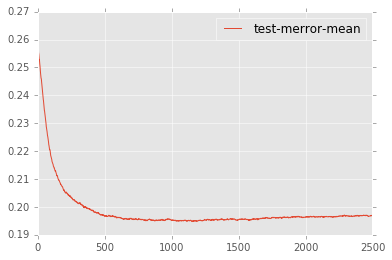

In [24]:
%matplotlib inline
cv.plot(y='test-merror-mean')

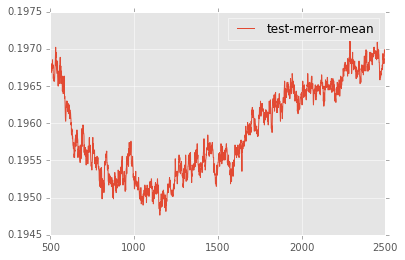

In [26]:
cv[500:].plot(y='test-merror-mean')

In [27]:
cv['test-merror-mean'].argmin()

1154

In [28]:
cv.loc[1154]

test-merror-mean     0.194764
test-merror-std      0.005720
train-merror-mean    0.026407
train-merror-std     0.000564
Name: 1154, dtype: float64

In [23]:
trees = 1154

In [24]:
bst = xgb.train(params, dtrain, num_boost_round=trees)

In [25]:
imps = pd.Series(bst.get_fscore()).sort_values()

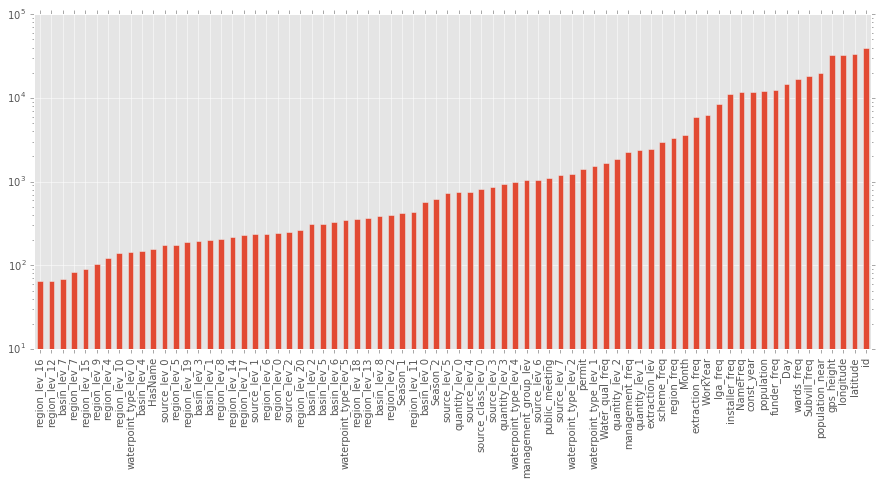

In [27]:
%matplotlib inline
imps.plot(kind='bar', figsize=(15,6),logy=True)

In [30]:
dtest = xgb.DMatrix(test)

In [31]:
p = bst.predict(dtest)

In [48]:
xgb_prediction = []
for line in range(0, len(p)):
    xgb_prediction.append(list(p[line]).index(max(p[line])))

In [49]:
xgb_prediction = classes_to_names(xgb_prediction)

In [50]:
xgb_prediction[1:10]

['functional',
 'functional',
 'non functional',
 'functional',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'functional']

In [52]:
sub = pd.DataFrame(sample.id)
sub['status_group'] = pd.DataFrame(xgb_prediction, columns=sample.columns[1:])

In [54]:
sub.to_csv('/home/dmitry/Desktop/DataDriven/xgb_prediction.csv', index=False)

Score is 0.8111 and the rank went up to 117th

## Neural Networks

In [75]:
sys.path.append('/usr/local/lib/python3.5/dist-packages')

In [76]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical

Using Theano backend.


In [101]:
nn = Sequential()
nn.add(Dense(128, input_dim=81, init='uniform'))
nn.add(Activation('sigmoid'))
nn.add(Dense(3, init='uniform'))
nn.add(Activation('softmax'))

opt = Adam(lr=1e-3)
nn.compile(loss='categorical_crossentropy', optimizer=opt)

In [81]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [ ]:
hist = nn.fit(ss.fit_transform(Xtr), to_categorical(ytr), nb_epoch=100, validation_data=(ss.transform(Xval), to_categorical(yval)))

Train on 50490 samples, validate on 8910 samples
Epoch 1/100
50490/50490 [==============================] - 8s - loss: 0.5808 - val_loss: 0.5895
Epoch 2/100
50490/50490 [==============================] - 8s - loss: 0.5721 - val_loss: 0.5861
Epoch 3/100
50490/50490 [==============================] - 8s - loss: 0.5652 - val_loss: 0.5756
Epoch 4/100
50490/50490 [==============================] - 8s - loss: 0.5581 - val_loss: 0.5722
Epoch 5/100
50490/50490 [==============================] - 8s - loss: 0.5523 - val_loss: 0.5714
Epoch 6/100
50490/50490 [==============================] - 8s - loss: 0.5467 - val_loss: 0.5669
Epoch 7/100
50490/50490 [==============================] - 8s - loss: 0.5415 - val_loss: 0.5712
Epoch 8/100
50490/50490 [==============================] - 8s - loss: 0.5363 - val_loss: 0.5642
Epoch 9/100
50490/50490 [==============================] - 8s - loss: 0.5306 - val_loss: 0.5623
Epoch 10/100
50490/50490 [==============================] - 8s - loss: 0.5273 - val_los

In [ ]:
start = 0
plt.plot(hist.history['loss'][start:])
plt.plot(hist.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])

## MetaClassifier

In [72]:
clf1_c = lr.fit(Xtr, ytr).predict_proba(Xval)

In [ ]:
dXtr = xgb.DMatrix(Xtr, label=ytr)
dXval = xgb.DMatrix(Xval, label=yval)
xgb_Xtr_only = xgb.train(params, dXtr, num_boost_round=trees)